In [1]:
import ast
import os
import shutil

import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import Image, clear_output
from sklearn.model_selection import StratifiedKFold, train_test_split

InteractiveShell.ast_node_interactivity = "all"

In [2]:
# !git clone https://github.com/ultralytics/yolov5  # clone repo
# clear_output()

In [3]:
os.chdir("/app/_data/yolov5")

In [4]:
!pip install -r requirements.txt
clear_output()

In [5]:
df = pd.read_csv("/app/_data/train.csv")

In [6]:
base_config = {
    "IMG_HEIGH": 1000,
    "IMG_WIDTH": 1000,
    "BATCH_SIZE": 8,
    "SEED": 42,
}

In [7]:
skf = StratifiedKFold(n_splits=5, random_state=base_config["SEED"], shuffle=True)
train_ids = []
val_ids = []
for train_index, valid_index in skf.split(df, df["class"]):
    train_ids.append(train_index)
    val_ids.append(valid_index)

In [8]:
train_ids[1]
val_ids[1]

array([   1,    3,    4, ..., 6327, 6330, 6332])

array([   0,    2,    8, ..., 6329, 6331, 6333])

In [9]:
def make_yolo_dataset(df, train_ids, val_ids, fold_name):
    path = "/app/_data/yolov5/yolo5_dataset/" + fold_name
    img_path = os.path.join(path, "images")
    labels_path = os.path.join(path, "labels")
    for dir_name in ["train", "val"]:
        os.makedirs(os.path.join(img_path, dir_name))
        os.makedirs(os.path.join(labels_path, dir_name))
    for ix in df.index.tolist():
        if ix in train_ids:
            dir_name = "train"
        elif ix in val_ids:
            dir_name = "val"
        img_name = df.loc[ix, "id_image"][:-6]
        img_w = df.loc[ix, "width"]
        img_h = df.loc[ix, "height"]
        shutil.copy(
            "/app/_data/jpg/" + img_name + ".jpg",
            os.path.join(img_path, dir_name, img_name + ".jpg"),
        )
        if df.loc[ix, "boxes"] == df.loc[ix, "boxes"]:
            boxes = ast.literal_eval(df.loc[ix, "boxes"])
            list_boxes = []
            for box in boxes:
                x_center = (box["x"] + box["width"] / 2) / img_w
                y_center = (box["y"] + box["height"] / 2) / img_h
                width = box["width"] / img_w
                height = box["height"] / img_h
                list_boxes.append(
                    [
                        str(0),
                        str(x_center),
                        str(y_center),
                        str(width),
                        str(height),
                    ]
                )
            with open(os.path.join(labels_path, dir_name, img_name + ".txt"), "w") as f:
                for j in range(len(list_boxes)):
                    text = " ".join(list_boxes[j])
                    f.write(text)
                    f.write("\n")

In [10]:
# shutil.rmtree('/app/_data/yolov5/yolo5_dataset/skf_0_42/')

In [10]:
make_yolo_dataset(df, train_ids[0], val_ids[0], "skf_0_42")

In [12]:
len(os.listdir("/app/_data/yolov5/yolo5_dataset/skf_0_42/labels/train"))
len(os.listdir("/app/_data/yolov5/yolo5_dataset/skf_0_42/images/train"))
len(os.listdir("/app/_data/yolov5/yolo5_dataset/skf_0_42/labels/val"))
len(os.listdir("/app/_data/yolov5/yolo5_dataset/skf_0_42/images/val"))

3431

5067

863

1267

In [13]:
# customize iPython writefile so we can write variables

from IPython.core.magic import register_line_cell_magic


@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, "w") as f:
        f.write(cell.format(**globals()))

In [14]:
if not os.path.exists("/app/_data/yolov5/yolo5_dataset/skf_0_42/DataFile"):
    os.mkdir("/app/_data/yolov5/yolo5_dataset/skf_0_42/DataFile")

In [15]:
%%writetemplate /app/_data/yolov5/yolo5_dataset/skf_0_42/DataFile/data.yaml
# train and val data
train: /app/_data/yolov5/yolo5_dataset/skf_0_42/images/train
val: /app/_data/yolov5/yolo5_dataset/skf_0_42/images/val
# number of classes
nc: 1
# class names
names: ["opacity"]

In [17]:
%%writetemplate /app/_data/yolov5/yolo5_dataset/skf_0_42/DataFile/customYOLOv5x.yaml
# parameters
nc: 1  # number of classes
depth_multiple: 1.33  # model depth multiple
width_multiple: 1.25  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [20]:
%%time
!python train.py --img 1000 --batch 4 --epochs 100 \
--data /app/_data/yolov5/yolo5_dataset/skf_0_42/DataFile/data.yaml \
--cfg /app/_data/yolov5/yolo5_dataset/skf_0_42/DataFile/customYOLOv5x.yaml \
--weights yolov5x.pt  \
--name yolov5x_0 \
--cache

github: skipping check (Docker image), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 v5.0-150-gabb2a96 torch 1.8.1+cu111 CUDA:0 (NVIDIA GeForce RTX 3090, 24268.3125MB)

Namespace(adam=False, artifact_alias='latest', batch_size=4, bbox_interval=-1, bucket='', cache_images=True, cfg='/app/_data/yolov5/yolo5_dataset/skf_0_42/DataFile/customYOLOv5x.yaml', data='/app/_data/yolov5/yolo5_dataset/skf_0_42/DataFile/data.yaml', device='', entity=None, epochs=100, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[1000, 1000], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='yolov5x_0', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/yolov5x_0', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=4, upload_dataset=False, weights='yolov5x.pt', workers=8, world_size=1)
tensorboard: Start with 'tensorboard 

In [11]:
make_yolo_dataset(df, train_ids[1], val_ids[1], "skf_1_42")

In [12]:
len(os.listdir("/app/_data/yolov5/yolo5_dataset/skf_1_42/labels/train"))
len(os.listdir("/app/_data/yolov5/yolo5_dataset/skf_1_42/images/train"))
len(os.listdir("/app/_data/yolov5/yolo5_dataset/skf_1_42/labels/val"))
len(os.listdir("/app/_data/yolov5/yolo5_dataset/skf_1_42/images/val"))

3429

5067

865

1267

In [13]:
# customize iPython writefile so we can write variables

from IPython.core.magic import register_line_cell_magic


@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, "w") as f:
        f.write(cell.format(**globals()))

In [14]:
if not os.path.exists("/app/_data/yolov5/yolo5_dataset/skf_1_42/DataFile"):
    os.mkdir("/app/_data/yolov5/yolo5_dataset/skf_1_42/DataFile")

In [15]:
%%writetemplate /app/_data/yolov5/yolo5_dataset/skf_1_42/DataFile/data.yaml
# train and val data
train: /app/_data/yolov5/yolo5_dataset/skf_1_42/images/train
val: /app/_data/yolov5/yolo5_dataset/skf_1_42/images/val
# number of classes
nc: 1
# class names
names: ["opacity"]

In [16]:
%%writetemplate /app/_data/yolov5/yolo5_dataset/skf_1_42/DataFile/customYOLOv5x.yaml
# parameters
nc: 1  # number of classes
depth_multiple: 1.33  # model depth multiple
width_multiple: 1.25  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
%%time
!python train.py --img 1024 --batch 4 --epochs 100 --data /app/_data/yolov5/yolo5_dataset/skf_1_42/DataFile/data.yaml --cfg /app/_data/yolov5/yolo5_dataset/skf_1_42/DataFile/customYOLOv5x.yaml --weights yolov5x.pt  --name yolov5x_1 --cache 


github: skipping check (Docker image), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 v5.0-150-gabb2a96 torch 1.8.1+cu111 CUDA:0 (NVIDIA GeForce RTX 3090, 24268.3125MB)

Namespace(adam=False, artifact_alias='latest', batch_size=4, bbox_interval=-1, bucket='', cache_images=True, cfg='/app/_data/yolov5/yolo5_dataset/skf_1_42/DataFile/customYOLOv5x.yaml', data='/app/_data/yolov5/yolo5_dataset/skf_1_42/DataFile/data.yaml', device='', entity=None, epochs=100, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[1024, 1024], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='yolov5x_1', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/yolov5x_13', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=4, upload_dataset=False, weights='yolov5x.pt', workers=8, world_size=1)
tensorboard: Start with 'tensorboard

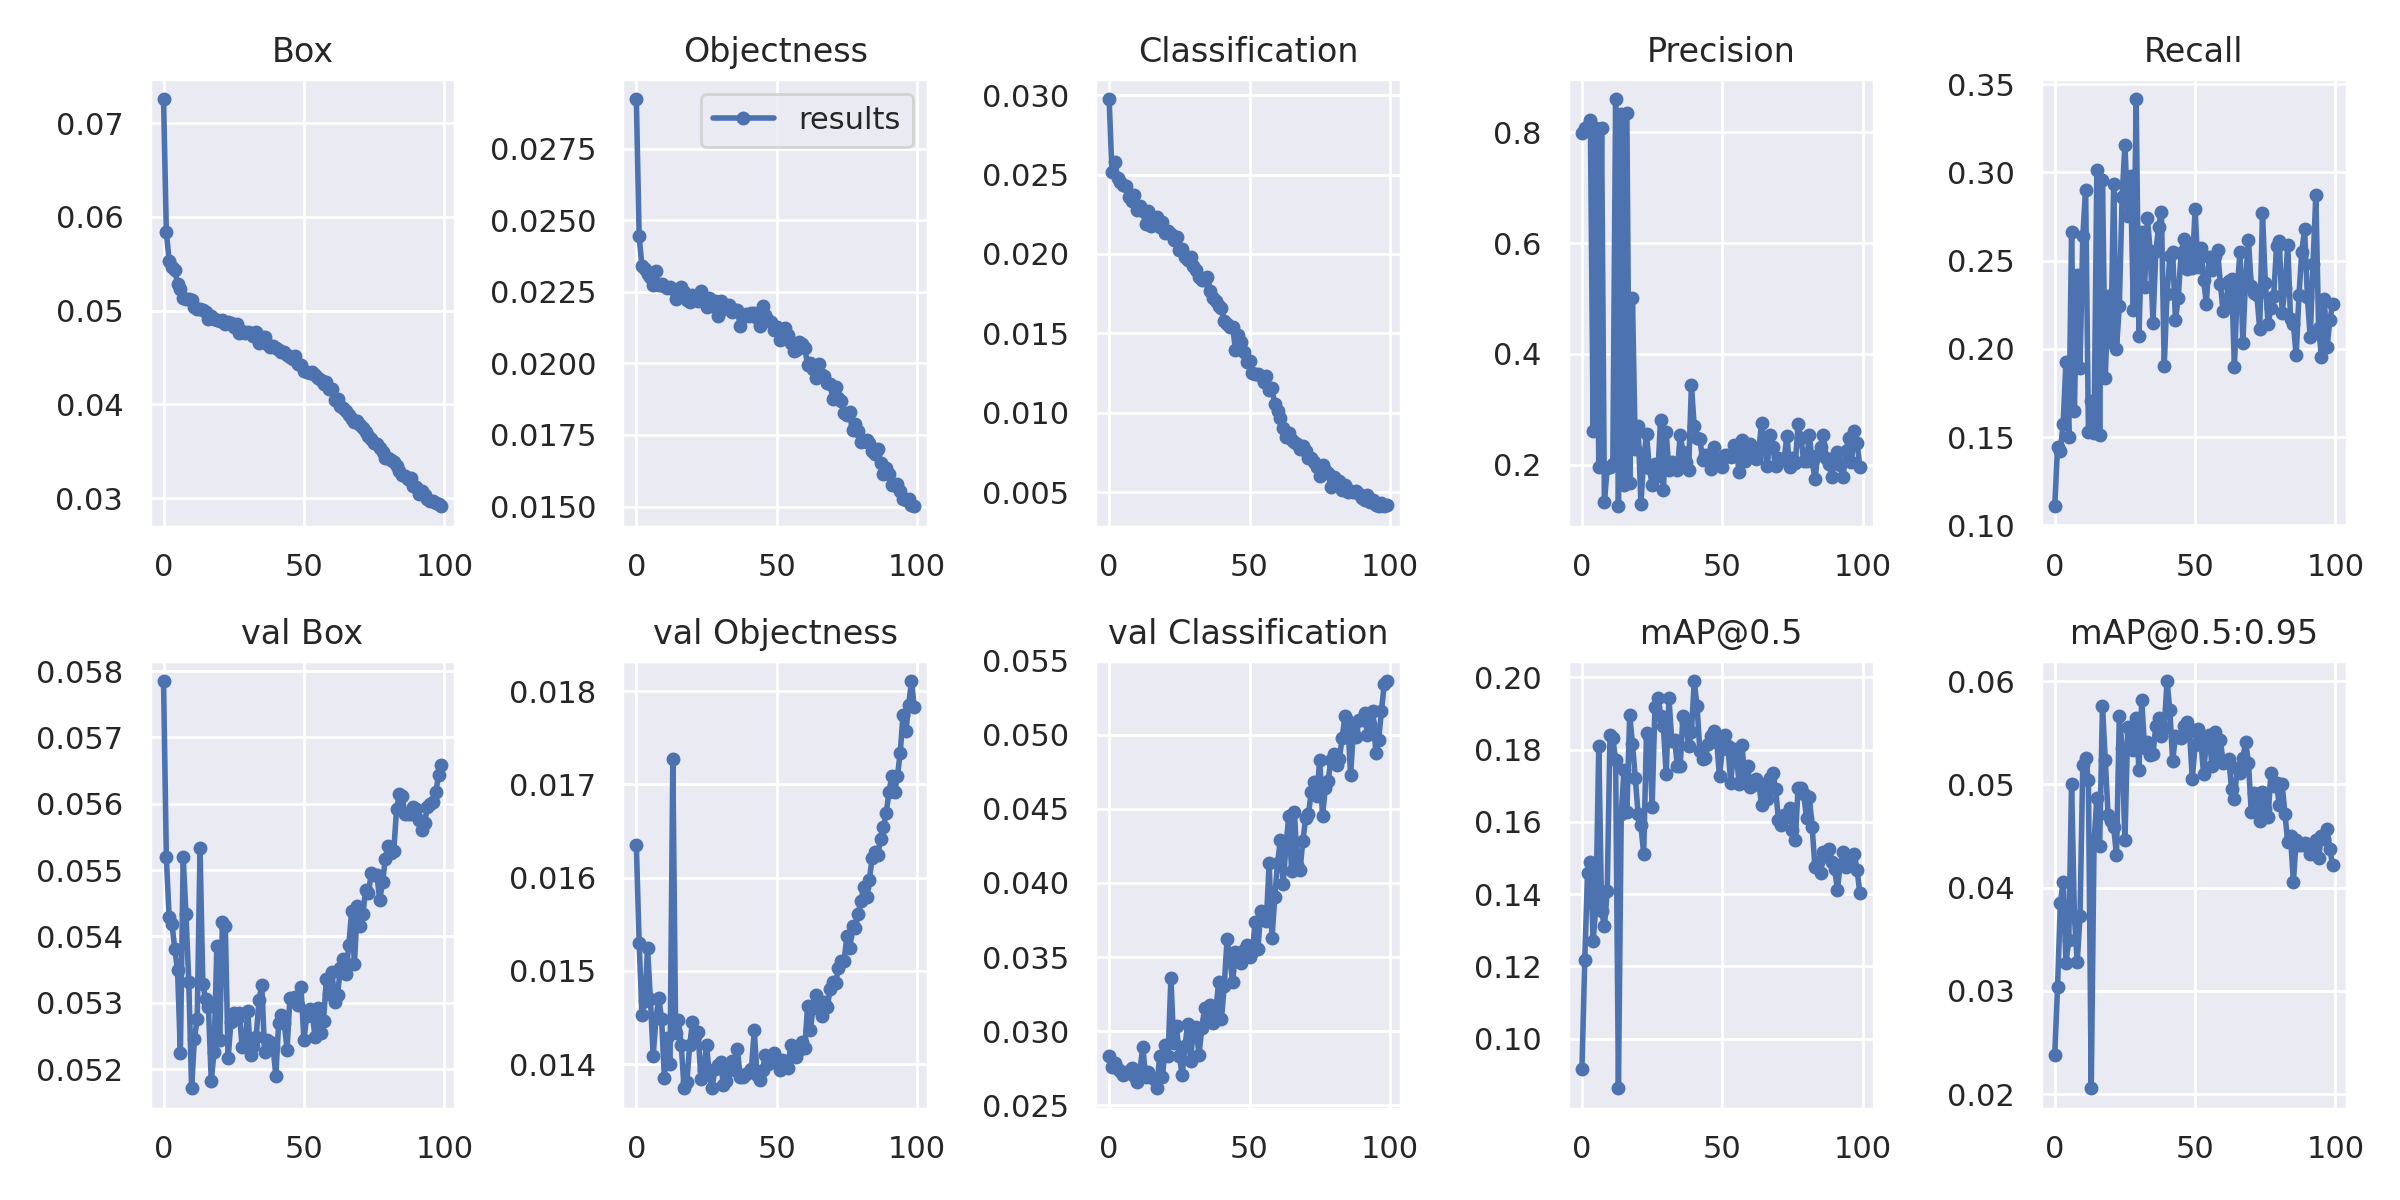

In [22]:
Image("./runs/train/Result15/results.png")

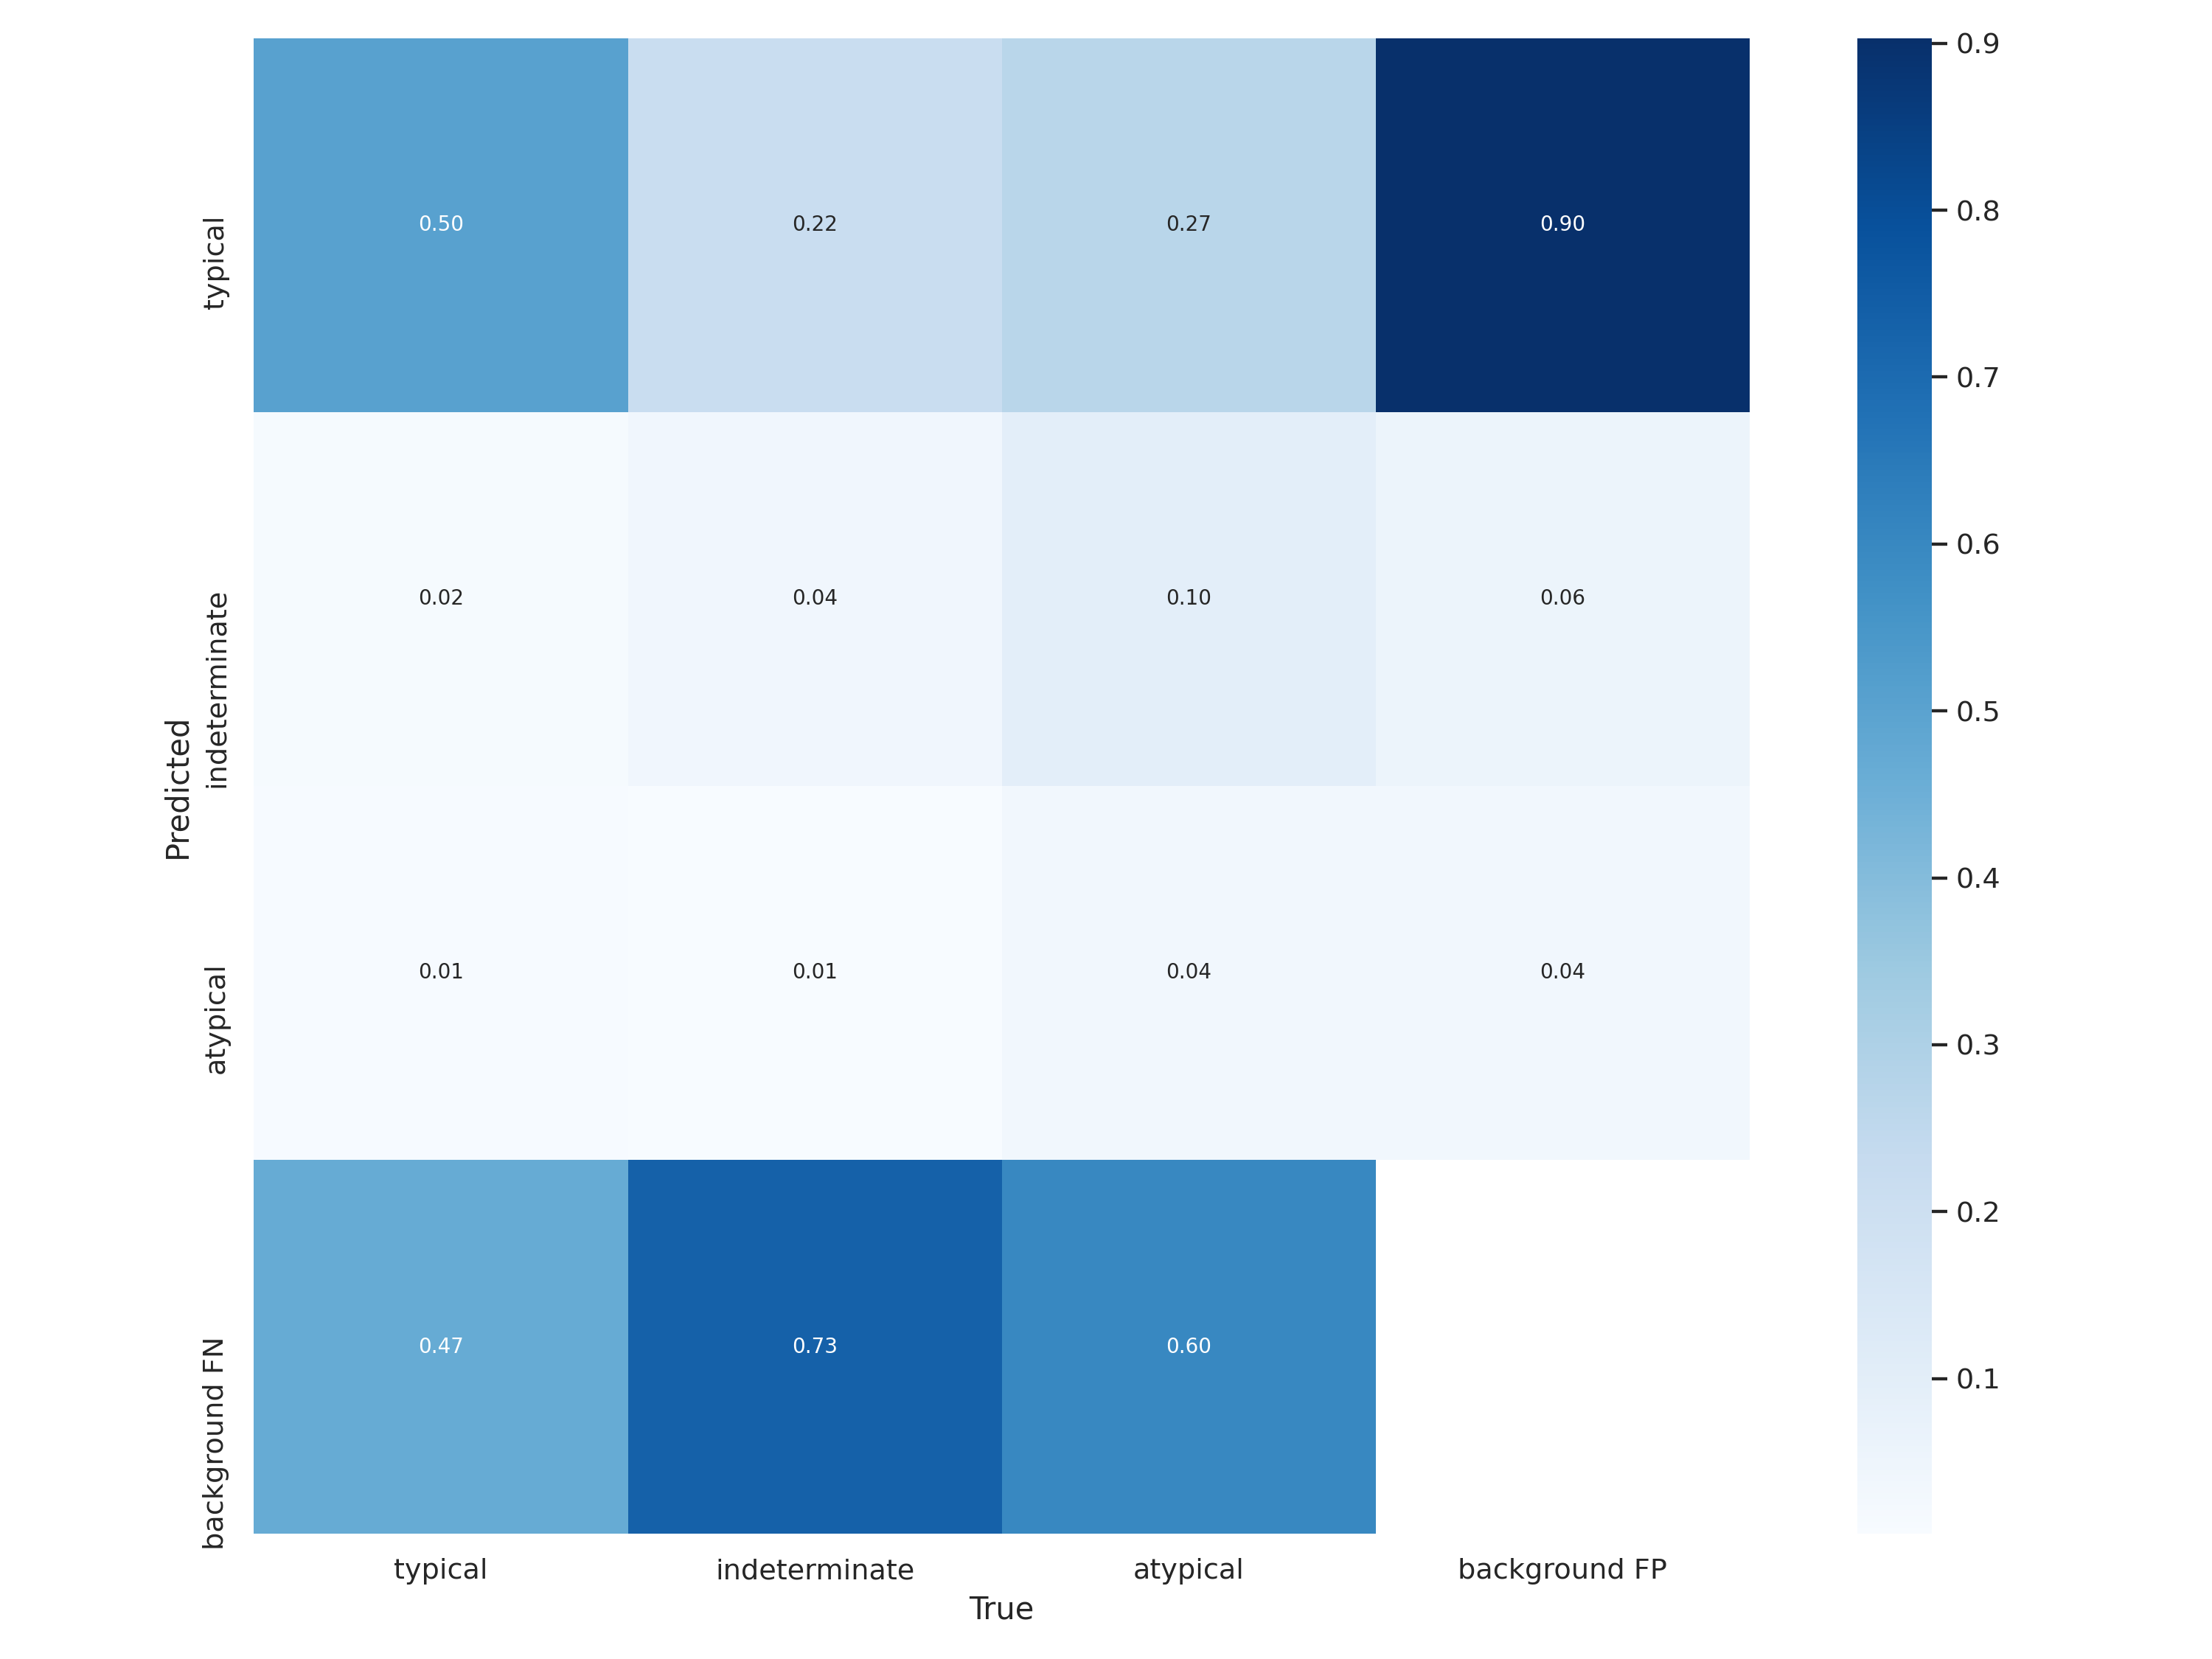

In [25]:
Image("/app/_data/Yolov5/yolov5/runs/train/Result15/confusion_matrix.png", width=600)

In [30]:
!python detect.py --img-size 640  --conf 0.3 --source /app/_data/yolo5_dataset/tr_test_42/images/val/ --weights /app/_data/Yolov5/yolov5/runs/train/Result15/weights/best.pt --augment --save-txt --save-conf

Namespace(agnostic_nms=False, augment=True, classes=None, conf_thres=0.3, device='', exist_ok=False, half=False, hide_conf=False, hide_labels=False, img_size=640, iou_thres=0.45, line_thickness=3, max_det=1000, name='exp', nosave=False, project='runs/detect', save_conf=True, save_crop=False, save_txt=True, source='/app/_data/yolo5_dataset/tr_test_42/images/val/', update=False, view_img=False, weights=['/app/_data/Yolov5/yolov5/runs/train/Result15/weights/best.pt'])
YOLOv5 🚀 v5.0-143-g3597d28 torch 1.8.1+cu111 CUDA:0 (NVIDIA GeForce RTX 3090, 24268.3125MB)

Fusing layers... 
Model Summary: 392 layers, 46611336 parameters, 0 gradients, 114.1 GFLOPs
image 1/1171 /app/_data/yolo5_dataset/tr_test_42/images/val/000a312787f2.jpg: 544x640 2 typicals, Done. (0.065s)
image 2/1171 /app/_data/yolo5_dataset/tr_test_42/images/val/0049814626c8.jpg: 544x640 2 typicals, Done. (0.054s)
image 3/1171 /app/_data/yolo5_dataset/tr_test_42/images/val/008ca392cff3.jpg: 544x640 Done. (0.054s)
image 4/1171 /app/

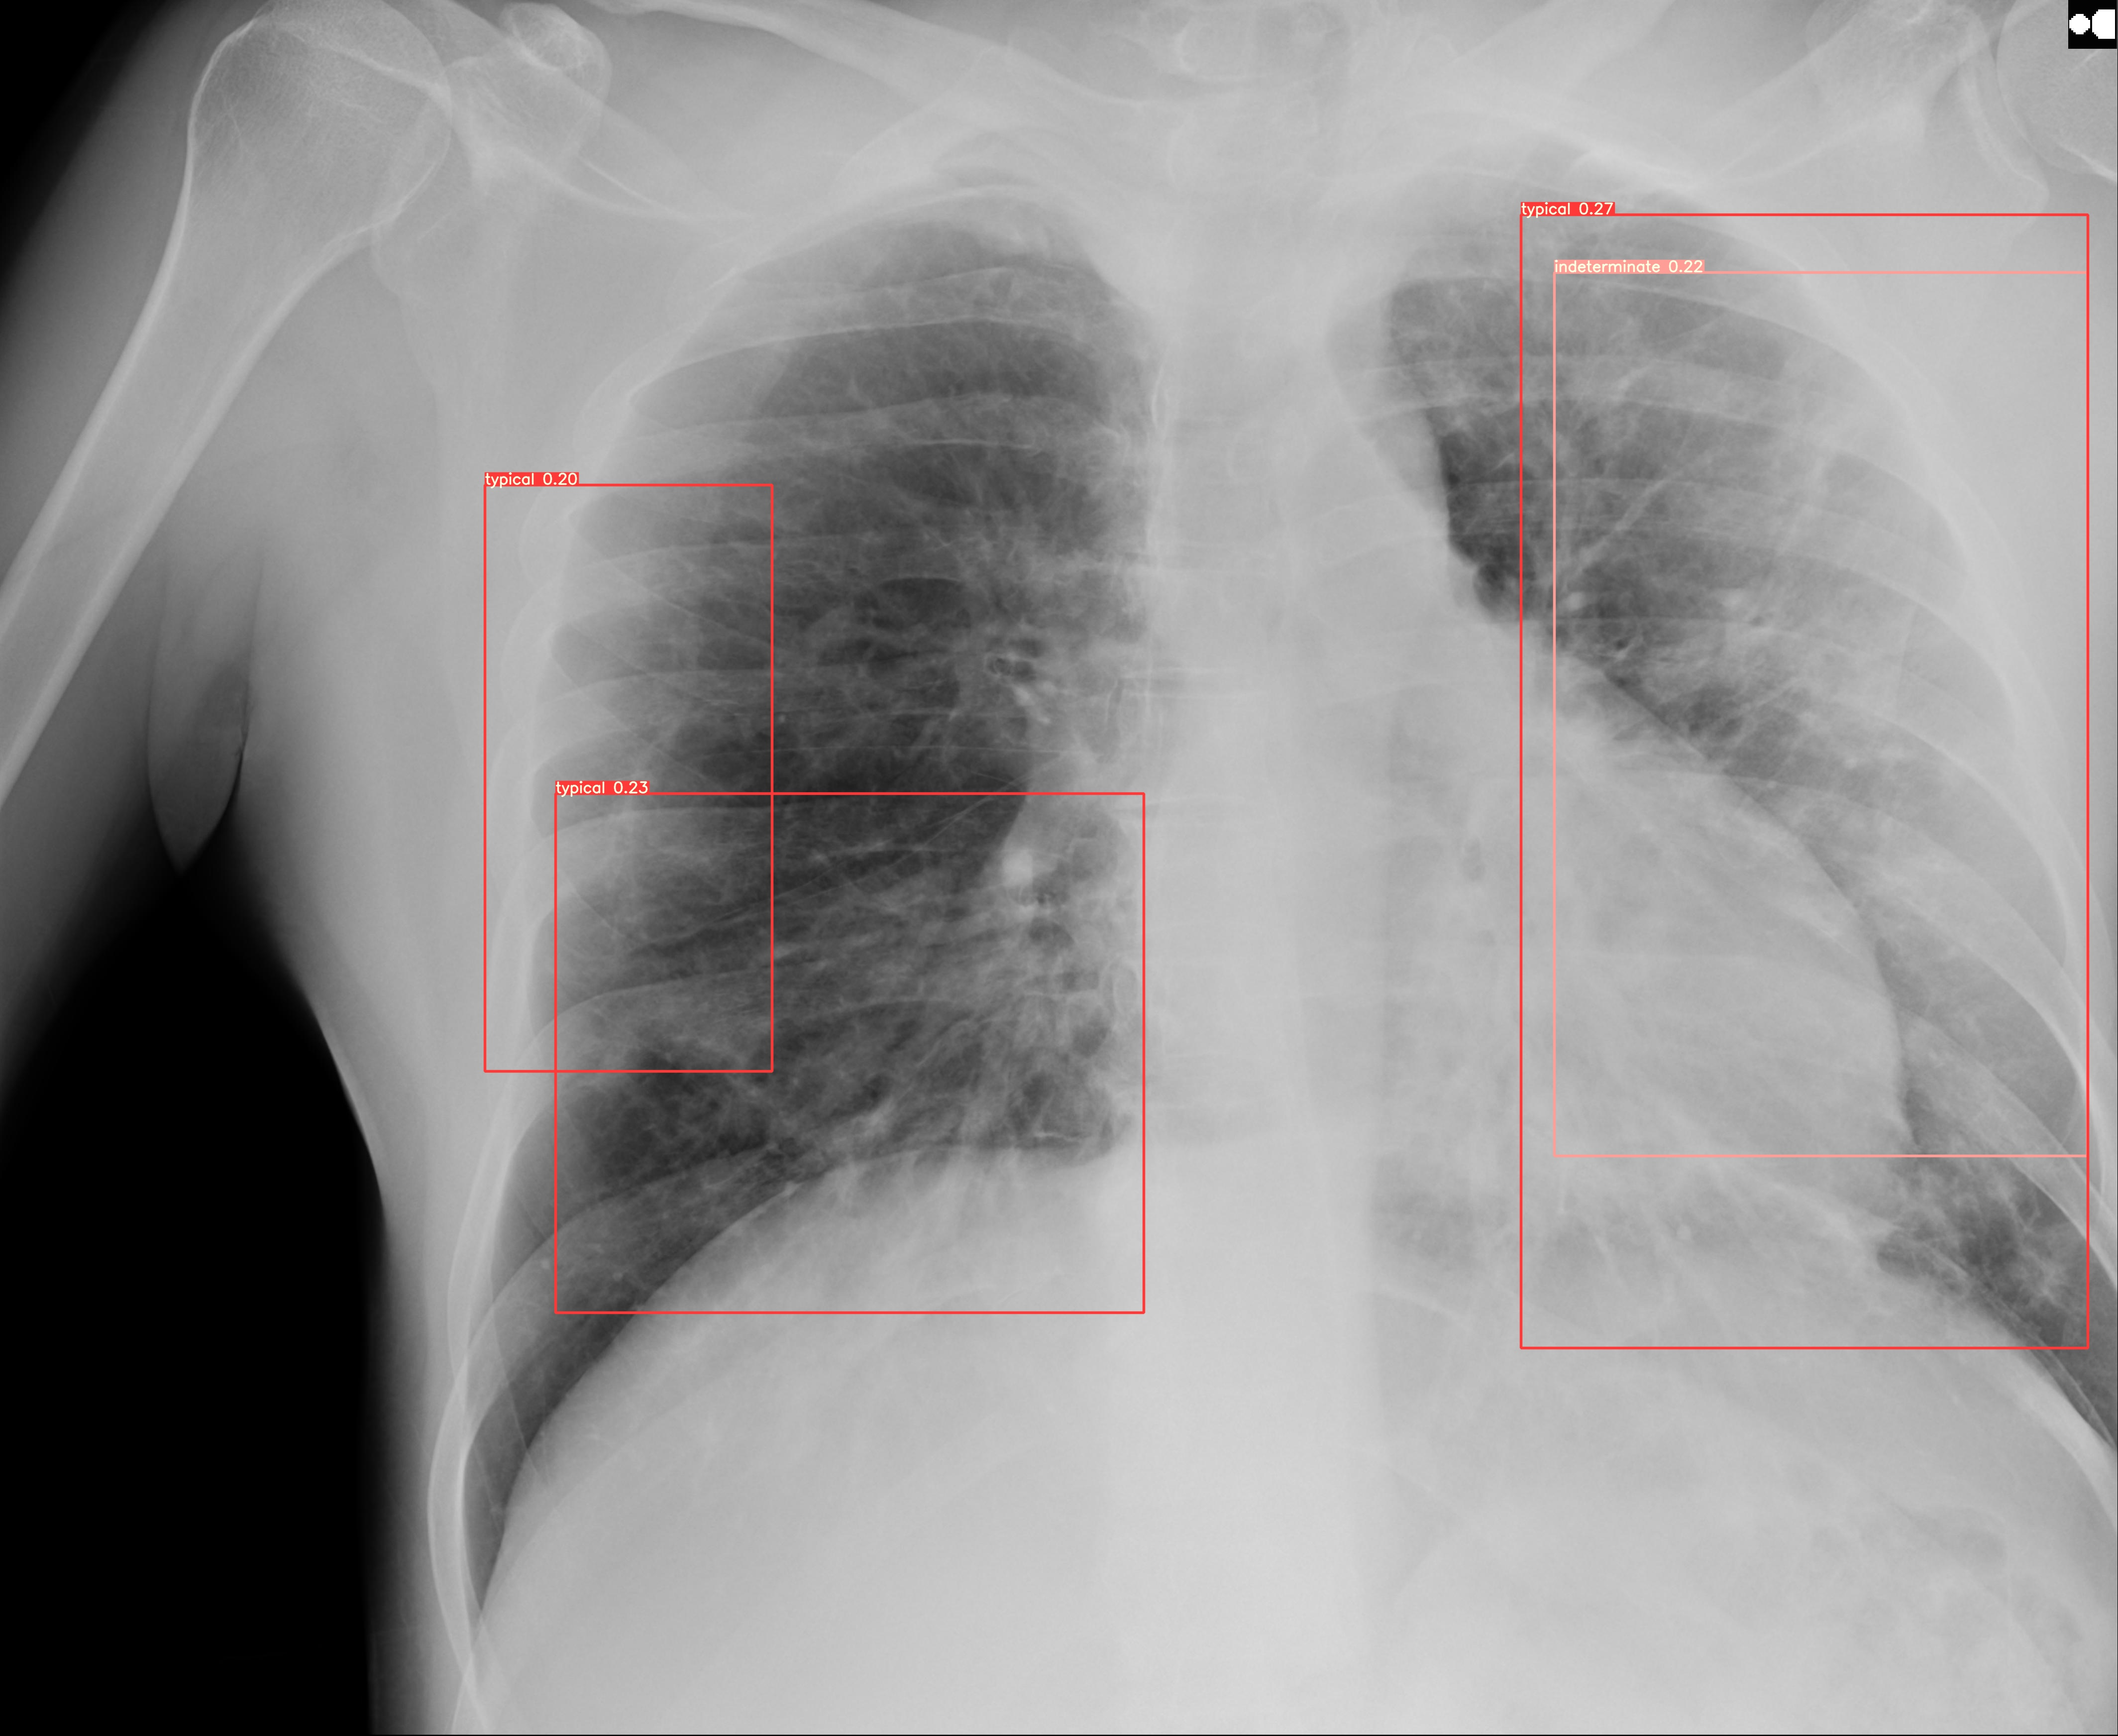

In [27]:
Image("/app/_data/Yolov5/yolov5/runs/detect/exp/ffdc682f7680.jpg")

In [31]:
for i in os.listdir("/app/_data/Yolov5/yolov5/runs/detect/exp2/labels/"):
    if ".jpg" not in i:
        print(i)

0b2269d46515.txt
c04e00187179.txt
8125a7add80b.txt
0ac7cf154967.txt
62235a2912fe.txt
b6959ada9a45.txt
7452ddd5b44b.txt
a2c5285c6fec.txt
586ea12cdc1c.txt
19fe0e60de1e.txt
57c6e5cf617a.txt
bc0043b0b2e4.txt
8eb882164ef4.txt
4e647a32aae9.txt
1f90178d3678.txt
23c05cf9e8e0.txt
e8c95d9d060f.txt
73c3ef06731e.txt
33ba04cc6e44.txt
ac92f478c77e.txt
12df1d79626b.txt
311b7f98fd08.txt
0452c373f62b.txt
ffcc16bbf428.txt
7183445f4d28.txt
345ff154ba07.txt
bd40b2e9ca96.txt
5aa205996c5a.txt
935219ffc68c.txt
3e63eefbf3d6.txt
a1279146145c.txt
83569c76974e.txt
8a6ff2ab86ee.txt
c38ec9e0f7a2.txt
4f11b62bab24.txt
f82f99deaae2.txt
5167ff5f6abe.txt
afb265f6b121.txt
c7d100353f74.txt
7fc06d300d14.txt
5d062f8686ff.txt
cb8664074d11.txt
0cd6f72ea375.txt
bb4464812bc3.txt
52bf81c57bb2.txt
58feda404eda.txt
c4fa3a69fae0.txt
422220ffba3a.txt
5cb08cd3bea3.txt
697ea3ceee9e.txt
da6cdab00d05.txt
4d94d9d0f8df.txt
b0411f8ff940.txt
8c1bc89a7fd8.txt
f7333f1c582f.txt
d3e9fb245247.txt
7b4eafaf6b6e.txt
ac94cb447ca7.txt
e946719a8ee0.t

In [ ]:
!pip uninstall wandb
clear_output()

Found existing installation: wandb 0.10.31
Uninstalling wandb-0.10.31:
  Would remove:
    /usr/local/bin/wandb
    /usr/local/bin/wb
    /usr/local/lib/python3.8/dist-packages/wandb-0.10.31.dist-info/*
    /usr/local/lib/python3.8/dist-packages/wandb/*
Proceed (y/n)? 